We generate gaussian random fields and then use the random fields as the time shift to obtain 
a sample of the following form 
$$\hat u\left( x, t \right)= u \left(x, t+ s_i (t,x)\right)$$

where $s_i( t,x) \sim S$, a sampled from a gaussian correlated field.
* We choose correlation length scale.
* We choose n-consequtive time steps as input to use as data for interpolation. 
* We need to normalize spacetime coordinated and use pytorch's 'grid_sample' function 

In [65]:
import os
import torch
import pandas as pd
import xarray as xr
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print('Active CUDA Device: GPU', torch.cuda.current_device())
device= torch.cuda.current_device()

Active CUDA Device: GPU 0


In [66]:
# Load the data 
dataset=xr.load_dataset('../data/stream_function_dataset_forcing_no_t_lr_128_dt=0.0002_save_freq=1600.nc')
dataset

<xarray.Dataset>
Dimensions:          (time: 365, lat: 128, lon: 128)
Coordinates:
  * time             (time) datetime64[ns] 2023-10-01 2023-10-02 ... 2024-09-29
  * lat              (lat) float64 -64.0 -62.99 -61.98 ... 61.98 62.99 64.0
  * lon              (lon) float64 -64.0 -62.99 -61.98 ... 61.98 62.99 64.0
Data variables:
    vorticity        (time, lat, lon) float64 -4.245 -1.971 ... 8.153 9.055
    stream_function  (time, lat, lon) float64 -0.4796 -0.3827 ... -1.821 -1.753
    sf_obs           (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    masks            (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [5]:
start_date='2023-10-01'

date_range = pd.date_range(start=start_date, periods=50, freq='D')

vorticity=dataset.vorticity.sel(time=date_range)
sf=dataset.stream_function.sel(time=date_range)

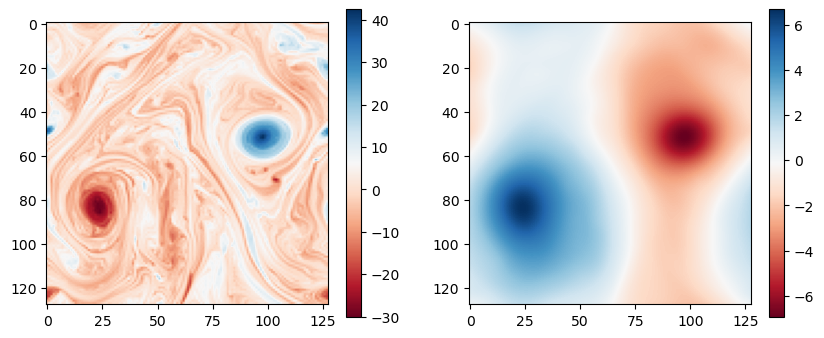

In [9]:
image1=vorticity.sel(time=start_date)
image2=sf.sel(time=start_date)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image1,cmap='RdBu')
plt.colorbar()
#image1=torch.from_numpy(image1.values).to(device)
plt.subplot(1,2,2)
plt.imshow(image2,cmap='RdBu')
plt.colorbar()

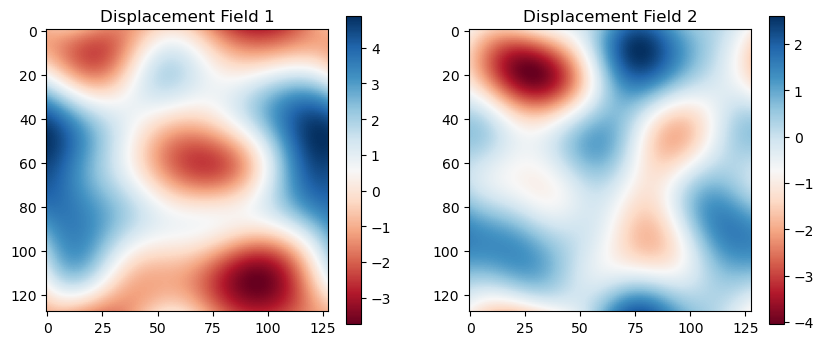

In [41]:
# Function to generate a correlated Gaussian random field with a high-frequency cutoff
def generate_gaussian_random_field_with_cutoff(size, variance, correlation_length, cutoff_frequency, device='cpu'):
    noise = torch.randn(size, size, device=device)

    # Perform Fourier transform of the noise
    noise_ft = torch.fft.fft2(noise)

    # Create frequency grids
    freq_x = torch.fft.fftfreq(size, device=device)
    freq_y = torch.fft.fftfreq(size, device=device)
    freq_x, freq_y = torch.meshgrid(freq_x, freq_y, indexing="ij")

    # Compute the radial frequency k
    k = torch.sqrt(freq_x**2 + freq_y**2)

    # Apply a low-pass filter to cutoff high frequencies (frequencies larger than cutoff_frequency)
    low_pass_filter = 100 * torch.exp(-0.5 * (k * correlation_length)**2)  # Correlating filter based on correlation length
    cutoff_mask = (k < cutoff_frequency).float()  # High-frequency cutoff
    filtered_noise_ft = noise_ft * low_pass_filter * cutoff_mask
    # Adding a time shift component...
    # in the above k 

    # We scale the Fourier components to get the desired variance in the spatial domain.
    current_variance = (filtered_noise_ft.abs()**2).mean().real  # Calculate current variance in Fourier domain
    #scaling_factor = torch.sqrt(variance / current_variance)
    scaled_filtered_noise_ft = filtered_noise_ft #* scaling_factor

    # Inverse Fourier transform to get the spatial domain field
    filtered_noise = torch.fft.ifft2(scaled_filtered_noise_ft).real

    return filtered_noise


size = 128  # Image size
correlation_length = 100.0  # Correlation length to control smoothness
cutoff_frequency = 0.4  # Frequency cutoff to remove high frequencies
variance=100

# Generate a Gaussian random field with a high-frequency cutoff
displacement_field_x = generate_gaussian_random_field_with_cutoff(size=128, variance=variance, correlation_length=correlation_length, cutoff_frequency=cutoff_frequency)
displacement_field_y = generate_gaussian_random_field_with_cutoff(size, variance, correlation_length, cutoff_frequency)

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.title("Displacement Field 1")
plt.imshow(displacement_field_x.cpu(), cmap='RdBu')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Displacement Field 2")
plt.imshow(displacement_field_y.cpu(), cmap='RdBu')
plt.colorbar()
plt.show()


In [25]:
# We then perform the time interpolation, by choosing random time shift. 
class PointwiseTimeSpaceInterpolatorGridSample:
    def __init__(self, data: torch.Tensor, time_steps: torch.Tensor):
        self.T, self.H, self.W = data.shape
        self.data = data.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, T, H, W]
        self.time_steps = time_steps  
        
    def interpolate(self, t_grid: torch.Tensor):
        """
        t_grid (torch.Tensor): 2D Tensor of shape [H, W] where each element corresponds to the
                                   time at which to interpolate at that grid point.
        
        Returns:
            torch.Tensor: 2D interpolated data of shape [H, W].
        """
        # Normalize the time grid to [-1, 1] as required by grid_sample
        t_min, t_max = self.time_steps.min(), self.time_steps.max()
        t_grid_normalized = 2 * (t_grid - t_min) / (t_max - t_min) - 1 
        
        # Create a grid of coordinates for `grid_sample`
        y_grid, x_grid = torch.meshgrid(
            torch.linspace(-1, 1, self.H), torch.linspace(-1, 1, self.W), indexing='ij'
        )
        
        # Stack the time, y, and x grids into a single grid
        t_grid_normalized = t_grid_normalized.unsqueeze(-1) 
        y_grid = y_grid.unsqueeze(-1)  # Shape: [H, W, 1]
        x_grid = x_grid.unsqueeze(-1)  # Shape: [H, W, 1]
        grid = torch.cat([y_grid, x_grid, t_grid_normalized], dim=-1)  
        grid = grid.unsqueeze(0).unsqueeze(0)  # Shape: [1, H, W, 3]
        
        interpolated_field = F.grid_sample(self.data, grid, mode='bilinear', align_corners=True)
        
        # Remove the batch and channel dimensions, but we can add many variables in the channels,
        interpolated_field = interpolated_field.squeeze(0).squeeze(0)  
        
        return interpolated_field


time_steps = torch.linspace(0, 19, 20).float()  # 20 time steps
data = torch.from_numpy(vorticity.values).float() 

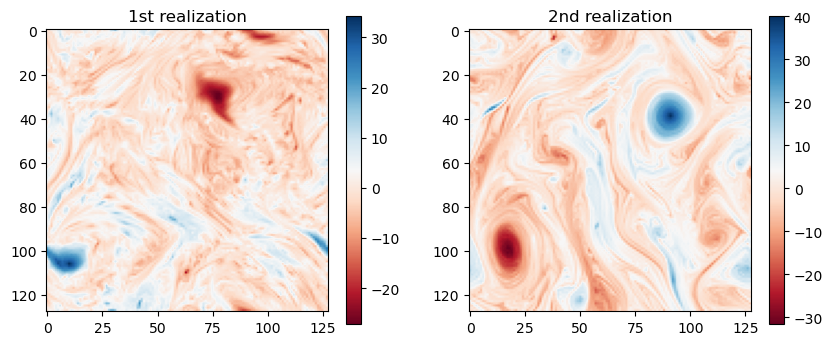

In [49]:
# Create a grid of desired interpolation times (e.g., random times for each point)

t_mean=12.0  
random_t_shift_grid1 = displacement_field_x + t_mean 
random_t_shift_grid2 = displacement_field_y + t_mean

#t_grid= torch.zeros(128,128)+ 12.45 

# Create interpolator
interpolator = PointwiseTimeSpaceInterpolatorGridSample(data, time_steps)

# Perform pointwise interpolation
interpolated_field_1 = interpolator.interpolate(random_t_shift_grid1)
interpolated_field_2 = interpolator.interpolate(random_t_shift_grid2)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(interpolated_field_1[0],cmap='RdBu')
plt.title('1st realization')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(vorticity[12].values,cmap='RdBu')
plt.title('2nd realization')
plt.colorbar()


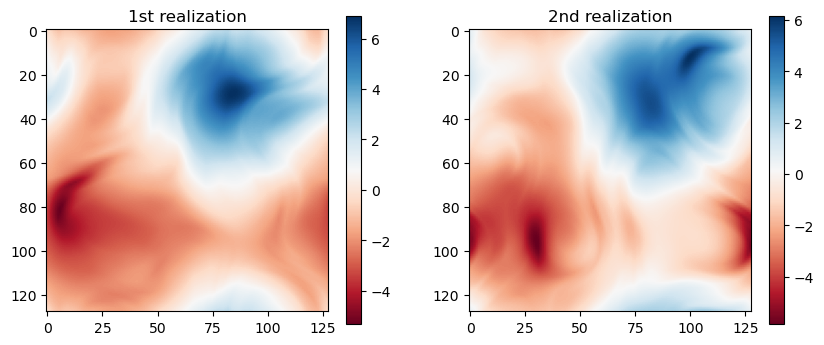

In [27]:
# Create interpolator for stream function field
data2= torch.from_numpy(sf.values).float()
interpolator2 = PointwiseTimeSpaceInterpolatorGridSample(data2, time_steps)

# Perform pointwise interpolation
sf_field_1 = interpolator2.interpolate(random_t_shift_grid1)
sf_field_2 = interpolator2.interpolate(random_t_shift_grid2)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(sf_field_1[0],cmap='RdBu')
plt.title('1st realization')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sf.values[0],cmap='RdBu')
plt.title('2nd realization')
plt.colorbar()


We now try to compute a different kind of random-field, which shifts data in space,

$$\hat u\left( x, t \right)= u \left(x + s_i (t, x), t\right)$$

To do this, 
* We choose correlation length scale. 
* we generate two random fields, each of which will give rise to a random shift in $x$ and shift in $y$.
* The displacements field added to the old grid points to get new grid.

In [70]:
def warp_field(field, dx, dy):
    """
    Warp a 2D field based on displacement fields dx and dy.
    
    field (torch.Tensor): Input field of shape (batch_size, channels, height, width)
    dx (torch.Tensor): X-displacement field of shape (batch_size, height, width)
    dy (torch.Tensor): Y-displacement field of shape (batch_size, height, width)
    """
    batch_size, _, height, width = field.shape
    
    # Create base grid
    y, x = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
    base_grid = torch.stack((x, y), dim=-1).float()
    
    # Add batch dimension and move to the same device as input field
    base_grid = base_grid.unsqueeze(0).repeat(batch_size, 1, 1, 1).to(field.device)
    
    print(base_grid.shape)
    # Apply displacements
    sample_grid = base_grid + torch.stack((dx, dy), dim=-1)
    sample_grid[..., 0] = sample_grid[..., 0] % width
    sample_grid[..., 1] = sample_grid[..., 1] % height
    
    # Normalize grid to [-1, 1] range
    sample_grid[..., 0] = 2 * sample_grid[..., 0] / (width - 1) - 1
    sample_grid[..., 1] = 2 * sample_grid[..., 1] / (height - 1) - 1
    
    # Perform sampling
    warped_field = F.grid_sample(field, sample_grid, mode='bicubic', padding_mode='reflection', align_corners=True)
    
    return warped_field


batch_size = 1
channels = 1
height, width = 128, 128

# Create a sample field (e.g., a gradient)
field = torch.from_numpy(vorticity[2].values).unsqueeze(0).unsqueeze(0).float()

dx = displacement_field_x * 5.0 
dy = displacement_field_y * 5.0

# Add batch dimension
dx = dx.unsqueeze(0)
dy = dy.unsqueeze(0)

# Perform warping
warped_field = warp_field(field, dx, dy)

print(f"Input field shape: {field.shape}")
print(f"Warped field shape: {warped_field.shape}")

torch.Size([1, 128, 128, 2])
Input field shape: torch.Size([1, 1, 128, 128])
Warped field shape: torch.Size([1, 1, 128, 128])


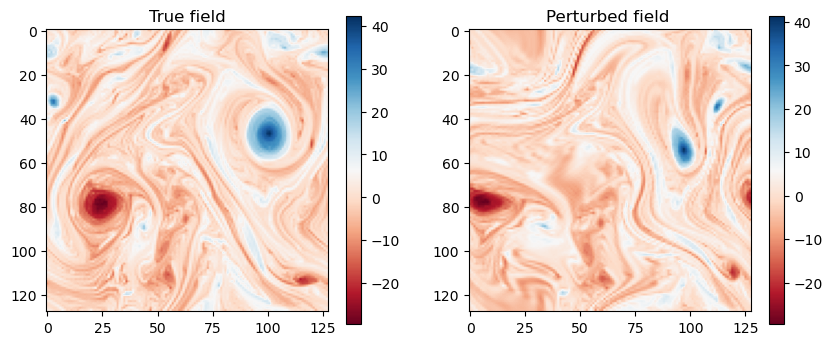

In [71]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(field.squeeze(0).squeeze(0),cmap='RdBu')
plt.title('True field')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(warped_field.squeeze(0).squeeze(0),cmap='RdBu')
plt.title('Perturbed field ')
plt.colorbar()

In [ ]:
# We can now generate temporally correlated gaussian random field. 
# How sensitive to the perturbatio is 4dvar.
# perturbation levels, 
# lambda metric to quantify the impact of the random perturbation.
# perturbation levels must be able to correspond to real data.
# initialization in 4dvarnet with perturbed initialization --- to test new experiments.
# Sampling 

# Create an elaborate notebook with all different schemes, 
# We have a way to create ensemble 4dvarnet using different schemes of perturbations. 
# We can create ensembles which can be reweighted to obtain like particle filtering method.
# Perturbation method can be used as a way to create augmentation datasets. 
# We also can move to real data after we calibrate the perturbation methods.?? 
# with the lambda metric for real daatsets.


In [ ]:
# Plot the true vorticity field and the perturbations, with the applied perturbation.
# Plot the true sf field and the perturbations, with the applied perturbations.
# A simple temporally correlated GRF...which can then be used to perturb different fields.
# Create a side by side plot of two animations where.
# Create lambda metric to quantify the impact of the random perturbations.  

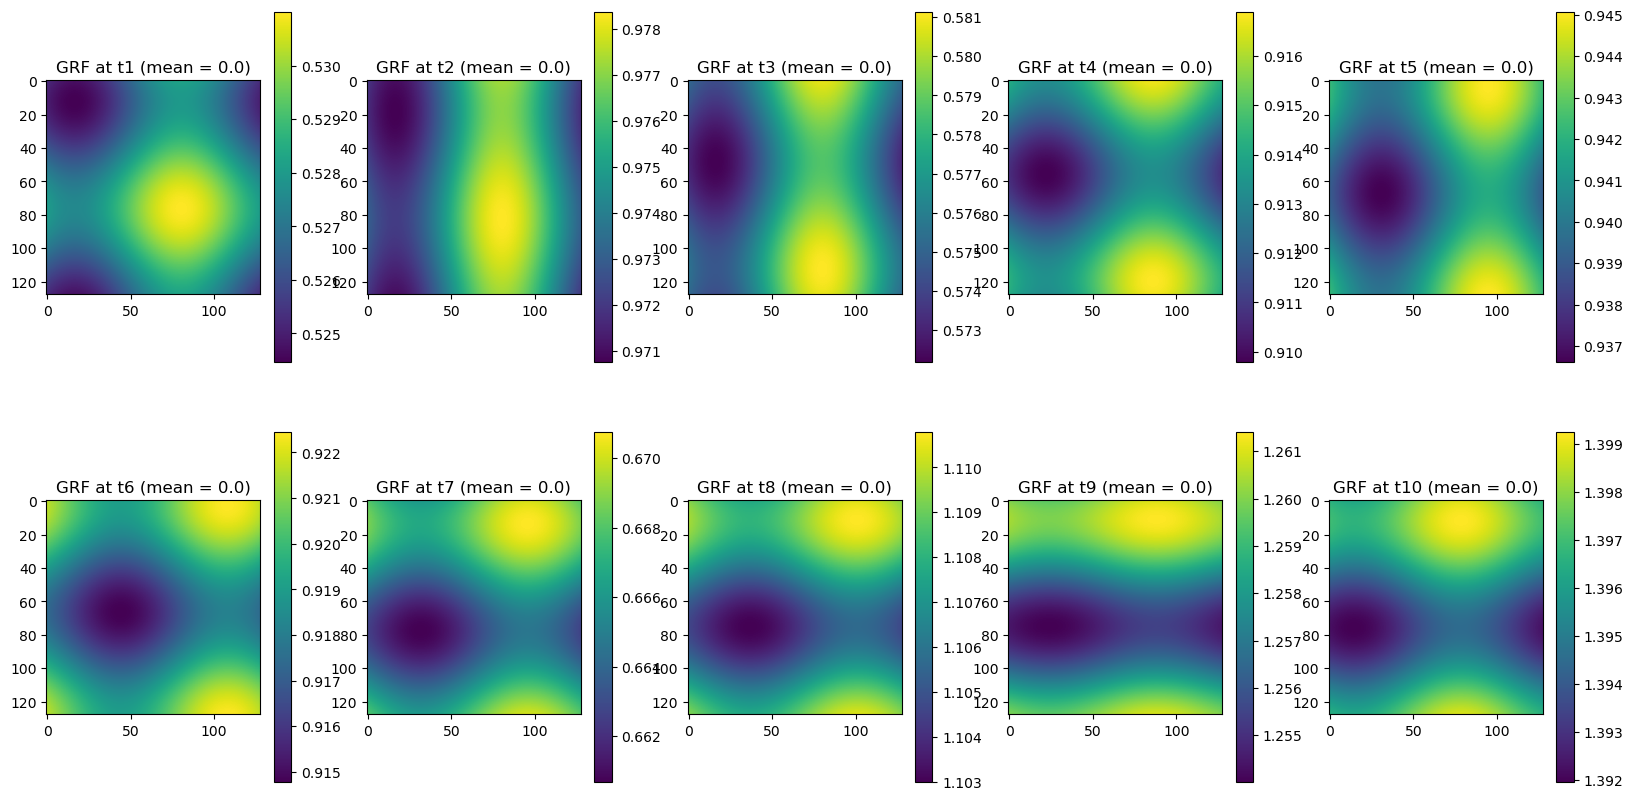

In [64]:
# Define grid size and correlation lengths
N = 128  # Grid size
L = 5.0  # Spatial correlation length
T_corr = 10.0  # Temporal correlation length
sigma = 100.0  # Standard deviation of the field
mean_value = 0.0  # Desired constant mean

# Define the time points for 10 fields
time_points = torch.linspace(0, 9, 10, device=device)  # Time steps t1 to t10

# Compute the temporal covariance matrix
C_temporal = torch.zeros((10, 10), device=device)
for i in range(10):
    for j in range(10):
        C_temporal[i, j] = torch.exp(-abs(time_points[i] - time_points[j]) / T_corr)

# Perform Cholesky decomposition to get the temporal correlation factors
L_chol = torch.linalg.cholesky(C_temporal)

# Generate independent Gaussian white noise for each time point
white_noises = torch.randn((10, N, N), device=device)

# Combine white noise using the Cholesky factors to induce temporal correlation
temporal_correlated_noises = torch.matmul(L_chol, white_noises.view(10, -1)).view(10, N, N)

# Generate 2D grid of wavenumbers for spatial correlation
kx = torch.fft.fftfreq(N, device=device) * N
ky = torch.fft.fftfreq(N, device=device) * N
k = torch.sqrt(kx[:, None]**2 + ky[None, :]**2)

# Spatial covariance (Power spectrum) for Gaussian covariance
P_k = sigma**2 * torch.exp(-0.5 * (k * L)**2)

# Fourier transform of the temporally correlated noises and generate fields
fields = []
for i in range(10):
    noise_ft = torch.fft.fft2(temporal_correlated_noises[i])
    field_ft = noise_ft * torch.sqrt(P_k)
    field = torch.fft.ifft2(field_ft).real
    fields.append(field)

# Add the constant mean to each field
fields_with_mean = [field + mean_value for field in fields]

# Plot the first 5 fields with the new mean
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(fields_with_mean[i].cpu().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title(f"GRF at t{i+1} (mean = {mean_value})")

for i in range(5, 10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(fields_with_mean[i].cpu().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title(f"GRF at t{i+1} (mean = {mean_value})")

plt.show()